In [234]:
# !cd training && rm -r Computing
#!cd training && rm  .ipynb_checkpoints 
!rm -r saved_model


rm: cannot remove 'saved_model': No such file or directory


In [224]:
# import opendatasets as od
import cv2
import tensorflow as tf
from tensorflow import keras
!pip3 install tensorflow_hub
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
# od.download("https://www.kaggle.com/datasets/arkadiyhacks/drinking-waste-classification")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [225]:
# Defining variable
data_root = ("training/")
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [202]:
# Split the data into validation and training
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 307 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [226]:
print (train_generator.class_indices)
print(train_generator.num_classes)

{'Crime-thriller': 0, 'Technology-Engineering': 1}
2


In [227]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Crime-thriller
Technology-Engineering

In [228]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Crime-Thriller' 'Technology-Engineering']


In [229]:
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_15 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                                 
 dense_19 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [235]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [236]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [237]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=15,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/15
39/39 [==============================] - 48s 1s/step - loss: 0.7935 - acc: 0.6282 - val_loss: 0.6003 - val_acc: 0.7231
Epoch 2/15
39/39 [==============================] - 43s 1s/step - loss: 0.5674 - acc: 0.7476 - val_loss: 0.5335 - val_acc: 0.7101
Epoch 3/15
39/39 [==============================] - 44s 1s/step - loss: 0.5337 - acc: 0.7484 - val_loss: 0.5196 - val_acc: 0.7362
Epoch 4/15
39/39 [==============================] - 45s 1s/step - loss: 0.4702 - acc: 0.7890 - val_loss: 0.5111 - val_acc: 0.7427
Epoch 5/15
39/39 [==============================] - 45s 1s/step - loss: 0.4731 - acc: 0.7914 - val_loss: 0.5070 - val_acc: 0.7329
Epoch 6/15
39/39 [==============================] - 43s 1s/step - loss: 0.3997 - acc: 0.8198 - val_loss: 0.4869 - val_acc: 0.7655
Epoch 7/15
39/39 [==============================] - 43s 1s/step - loss: 0.4324 - acc: 0.8093 - val_loss: 0.5095 - val_acc: 0.7296
Epoch 8/15
39/39 [==============================] - 45s 1s/step - loss: 0.4454 - acc: 0.80

In [238]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


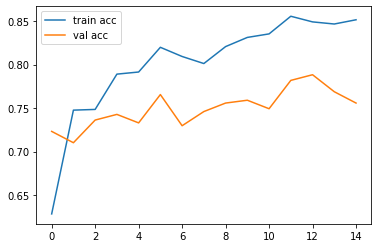

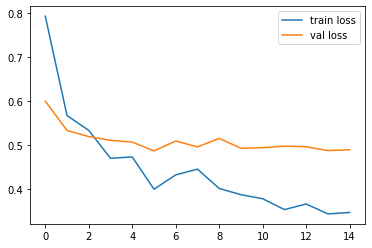

In [239]:
# accuracies
plt.plot(hist['acc'], label='train acc')
plt.plot(hist['val_acc'], label='val acc')
plt.legend()
plt.show()

# loss
plt.plot(hist['loss'], label='train loss')
plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.show()

In [240]:
CLASS_NAMES = ['Crime-Thriller', 'Technology-Engineering']

new_model = tf.keras.models.load_model('saved_model/my_model')
# print(new_model.summary())
test_path = "/content/testing"

for image in os.listdir(test_path):
    if(image == '.ipynb_checkpoints'):
        continue
    img = cv2.imread(test_path+"/"+image)
#     plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
#     # as opencv loads in BGR format by default, we want to show it in RGB.
#     plt.show()
    
    img = cv2.resize(img,(224,224))
    img = np.expand_dims(img,0)
    predict = new_model.predict(img)
    print(image)
#     print(predict)
    result = CLASS_NAMES[predict.argmax(axis=1)[0]]
    print(result)

crime_11.jpg
Technology-Engineering
engineering_01.jpg
Technology-Engineering
crime_10.jpg
Technology-Engineering
crime_09.jpg
Technology-Engineering
crime_07.jpg
Technology-Engineering
0000003.jpg
Technology-Engineering
0000001.jpg
Technology-Engineering
crime_05.jpg
Technology-Engineering
crime_03.jpg
Crime-Thriller
crime_02.jpg
Technology-Engineering
crime_04.jpg
Technology-Engineering
crime_01.jpg
Technology-Engineering
crime_08.jpg
Technology-Engineering


In [218]:
CLASS_NAMES = ['Crime-Thriller', 'Technology-Engineering']
result = CLASS_NAMES[predict.argmax(axis=1)[0]]
print(result)

Technology-Engineering
